In [1]:
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tqdm 
from collections import defaultdict

from itertools import combinations

In [2]:
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='grade3')

In [3]:
df = pd.read_csv('outputs/analysis_lists/all_analysis_week_12.csv')
reg = pd.read_csv('feb16-mar15_data/beneficiary/ai_registration-20210216-20210315.csv', sep='\t')
interv_df = pd.read_csv('outputs/interventions.csv')
analysis_df = pd.read_csv('outputs/state-cluster-whittle-E_C.csv')
pilot_trans_df_small = pd.read_csv('outputs/pilot_transitions.csv')
pilot_trans_df = pd.read_csv('outputs/pilot_transitions_5months.csv')

In [4]:
with open('policy_dump.pkl', 'rb') as fr:
  pilot_user_ids, pilot_static_features, cls, cluster_transition_probabilities, m_values, q_values = pickle.load(fr)
fr.close()

/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [5]:
def get_transition_probabilities(beneficiaries, transitions, min_support=5):
    transitions = transitions[transitions['user_id'].isin(beneficiaries)]

    i_transitions = transitions[transitions['action']=='Intervention']
    n_i_transitions = transitions[transitions['action']=='No Intervention']

    i_L = i_transitions[i_transitions['pre-action state']=="L"]
    i_H = i_transitions[i_transitions['pre-action state']=="H"]

    i_L_L = i_L[i_L['post-action state']=="L"]
    i_L_H = i_L[i_L['post-action state']=="H"]

    i_H_L = i_H[i_H['post-action state']=="L"]
    i_H_H = i_H[i_H['post-action state']=="H"]

    n_i_L = n_i_transitions[n_i_transitions['pre-action state']=="L"]
    n_i_H = n_i_transitions[n_i_transitions['pre-action state']=="H"]

    n_i_L_L = n_i_L[n_i_L['post-action state']=="L"]
    n_i_L_H = n_i_L[n_i_L['post-action state']=="H"]

    n_i_H_L = n_i_H[n_i_H['post-action state']=="L"]
    n_i_H_H = n_i_H[n_i_H['post-action state']=="H"]

    transition_probabilities = dict()
    if i_L.shape[0] >= min_support:
        transition_probabilities['P(L, I, L)'] = i_L_L.shape[0] / i_L.shape[0]
        transition_probabilities['P(L, I, H)'] = i_L_H.shape[0] / i_L.shape[0]
    else:
        transition_probabilities['P(L, I, L)'] = np.nan
        transition_probabilities['P(L, I, H)'] = np.nan

    if i_H.shape[0] >= min_support:
        transition_probabilities['P(H, I, L)'] = i_H_L.shape[0] / i_H.shape[0]
        transition_probabilities['P(H, I, H)'] = i_H_H.shape[0] / i_H.shape[0]
    else:
        transition_probabilities['P(H, I, L)'] = np.nan
        transition_probabilities['P(H, I, H)'] = np.nan
    
    if n_i_L.shape[0] >= min_support:
        transition_probabilities['P(L, N, L)'] = n_i_L_L.shape[0] / n_i_L.shape[0]
        transition_probabilities['P(L, N, H)'] = n_i_L_H.shape[0] / n_i_L.shape[0]
    else:
        transition_probabilities['P(L, N, L)'] = np.nan
        transition_probabilities['P(L, N, H)'] = np.nan

    if n_i_H.shape[0] >= min_support:
        transition_probabilities['P(H, N, L)'] = n_i_H_L.shape[0] / n_i_H.shape[0]
        transition_probabilities['P(H, N, H)'] = n_i_H_H.shape[0] / n_i_H.shape[0]
    else:
        transition_probabilities['P(H, N, L)'] = np.nan
        transition_probabilities['P(H, N, H)'] = np.nan

    return transition_probabilities, {'P(L, I, L)': i_L_L.shape[0], 'P(L, I, H)': i_L_H.shape[0], 'P(H, I, L)': i_H_L.shape[0], 'P(H, I, H)': i_H_H.shape[0], 'P(L, N, L)': n_i_L_L.shape[0], 'P(L, N, H)': n_i_L_H.shape[0], 'P(H, N, L)': n_i_H_L.shape[0], 'P(H, N, H)': n_i_H_H.shape[0]}
user_probs, sup = get_transition_probabilities([pilot_user_ids[0]], pilot_trans_df)

all_probs = pd.DataFrame(columns = ['user_id'] + list(user_probs.keys()))
for user_id in tqdm.tqdm(pilot_user_ids):
        user_probs, sup = get_transition_probabilities([user_id], pilot_trans_df)
        user_probs['user_id'] = user_id
        all_probs = all_probs.append(user_probs, ignore_index=True)

100%|██████████| 23008/23008 [03:40<00:00, 104.54it/s]


In [7]:
bool_vec = (~all_probs['P(L, N, L)'].isna()) & (~all_probs['P(H, N, L)'].isna())
bool_vec.sum()

10159

In [8]:
def gower_dist_func(x, y, **kwargs):
    dist = 0
#     print(x)
#     print(kwargs['ranges'])
    for i in range(len(x)):
        if kwargs['is_cat_vector'][i]:
            if x[i]==y[i]:
                feature_dist = 0
            else:
                feature_dist = 1
        else:
                feature_dist = np.abs(x[i]-y[i]) / kwargs['ranges'][i]
        dist+=feature_dist
    return dist

In [49]:
from sklearn.neighbors import DistanceMetric
from sklearn.preprocessing import normalize

from sklearn.neighbors import NearestNeighbors
import numpy as np

cat_bool = np.ones(pilot_static_features.shape[1]).astype(bool)
cat_bool[[0, 2, 3, 4, 5, 6, 7]] = False

Xd = pd.DataFrame(pilot_static_features[bool_vec][:1000])

ranges = np.ptp(pilot_static_features, axis=0)
nbrs = NearestNeighbors(n_neighbors=30, metric=gower_dist_func,
                        metric_params={
                                      "ranges":ranges,
                                      "is_cat_vector":cat_bool}).\
                        fit(Xd.values)
distances, indices = nbrs.kneighbors(Xd.values)
indices
# distances, indices = nbrs.kneighbors(gower_distance(Xd))

array([[  0, 183, 985, ..., 127, 993, 150],
       [  1, 730,   9, ..., 942, 913,  91],
       [  2, 341, 239, ..., 809, 799, 913],
       ...,
       [997, 525, 866, ..., 425, 704, 996],
       [998, 188, 564, ..., 573, 164, 490],
       [999, 944, 145, ..., 449, 758, 974]])

0it [00:00, ?it/s]<ipython-input-53-474f8402b2a7>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neigh_trans_df["user_id"] = base_benef
20it [00:00, 188.27it/s]


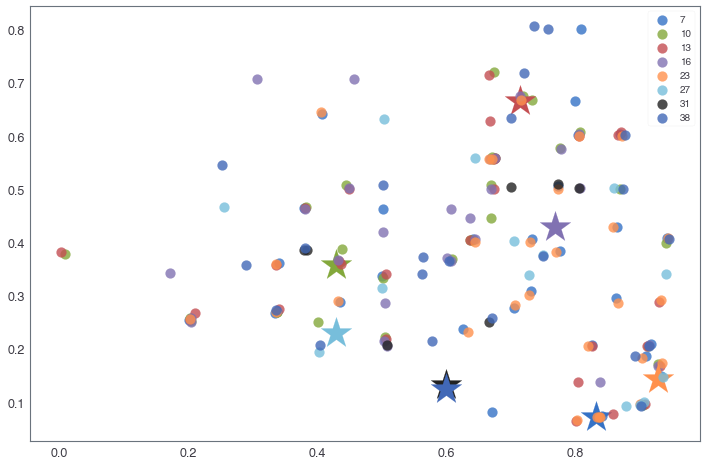

In [53]:

plt.figure(figsize=(12, 8))
subset_idx = all_probs[bool_vec].index
min_non_nan_points = 5
dist_thresh = 4

for idx, i in tqdm.tqdm(enumerate(subset_idx)):
#     if idx<100:
#         continue
    if idx>=20:
        break
    if idx%2==0:
        continue
    base_benef = pilot_user_ids[bool_vec][indices[idx][0]]
    neigh_benefs = pilot_user_ids[bool_vec][indices[idx][1:]]
    nearest_n = len(distances[idx][distances[idx]<dist_thresh])
    if nearest_n<min_non_nan_points:
        continue
    neigh_benefs = neigh_benefs[:nearest_n]
    neigh_trans_df = pilot_trans_df[pilot_trans_df.user_id.isin(neigh_benefs)]
    neigh_trans_df["user_id"] = base_benef

    base_trans_probs = all_probs[all_probs.user_id==base_benef][['P(L, N, L)', 'P(H, N, L)']]
    neigh_trans_probs = all_probs[all_probs.user_id.isin(neigh_benefs)][['P(L, N, L)', 'P(H, N, L)']]

    if pd.isna(base_trans_probs).values.sum():
        continue
    if (~neigh_trans_probs.iloc[:, 0].isna() & ~neigh_trans_probs.iloc[:, 1].isna()).sum() < min_non_nan_points:
        continue
#     print('non nan',
#          (~neigh_trans_probs.iloc[:, 0].isna() & ~neigh_trans_probs.iloc[:, 1].isna()).sum())
    e = np.random.uniform(0, 0.01, neigh_trans_probs.shape)
    my_plot = plt.scatter(neigh_trans_probs.iloc[:, 0]+e[:, 0],
                neigh_trans_probs.iloc[:, 1]+e[:, 1],
               label=str(i), s=100, alpha=0.8)
    plt.scatter(base_trans_probs.values[0][0], base_trans_probs.values[0][1],
                marker='*', label='', alpha=1,
                color=my_plot.get_facecolors()[0], s=1050)
#     print('good')
plt.legend(fontsize=10)
plt.grid(b=None)


In [19]:
distances[0]

array([0.        , 2.1025641 , 2.37468982, 2.50951199, 2.80851943,
       2.81513647, 2.99793217, 3.21588089, 4.01075269, 4.07526881,
       4.07940446, 4.08767576, 4.12820513, 4.12820513, 4.26716294,
       4.44499586, 4.44913151, 4.54301075, 4.57485525, 4.57485525,
       4.6025641 , 4.60918114, 4.61331679, 4.65425972, 4.71174524,
       4.73118279, 4.78205128, 4.79528536, 4.80314308, 4.82092638])

In [48]:

subset_idx = all_probs[bool_vec].index
min_non_nan_points = 5
dist_thresh = 4

for idx, i in tqdm.tqdm(enumerate(subset_idx)):
    if idx>=200:
        break
    if idx%2==0:
        continue
    base_benef = pilot_user_ids[bool_vec][indices[idx][0]]
    neigh_benefs = pilot_user_ids[bool_vec][indices[idx][1:]]
    nearest_n = len(distances[idx][distances[idx]<dist_thresh])

    if nearest_n<min_non_nan_points:
        continue
        
    neigh_benefs = neigh_benefs[:nearest_n]
    neigh_trans_df = pilot_trans_df[pilot_trans_df.user_id.isin(neigh_benefs)]
    neigh_trans_df["user_id"] = base_benef

    base_trans_probs = all_probs[all_probs.user_id==base_benef][['P(L, N, L)', 'P(H, N, L)']]
    neigh_trans_probs = all_probs[all_probs.user_id.isin(neigh_benefs)][['P(L, N, L)', 'P(H, N, L)']]

    if pd.isna(base_trans_probs).values.sum():
        continue
    non_nan_points = (~neigh_trans_probs.iloc[:, 0].isna() & ~neigh_trans_probs.iloc[:, 1].isna())
    
    if non_nan_points.sum() < min_non_nan_points:
        continue

    e = np.random.uniform(0, 0.01, neigh_trans_probs.shape)
    std = neigh_trans_probs[non_nan_points].std().values
    mean = neigh_trans_probs[non_nan_points].mean().values
    print(f'neighbors mean: {mean}, std: {std} ')
    print('base: ', base_trans_probs.values )
    
    random_pts = all_probs[~all_probs[['P(L, N, L)', 'P(H, N, L)']].isna().\
                           sum(axis=1).astype(bool)].sample(1000)\
                          [['P(L, N, L)', 'P(H, N, L)']]
    std = random_pts.std().values
    mean = random_pts.mean().values
    print(f'random mean: {mean}, std: {std} \n')



0it [00:00, ?it/s]<ipython-input-48-7de72e4f278c>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neigh_trans_df["user_id"] = base_benef
56it [00:00, 274.93it/s]

neighbors mean: [0.66119245 0.37705489], std: [0.20738224 0.22805339] 
base:  [[0.83333333 0.07142857]]
random mean: [0.67459358 0.35727605], std: [0.22571918 0.16783976] 

neighbors mean: [0.55723304 0.4783189 ], std: [0.29191728 0.16185148] 
base:  [[0.42857143 0.35714286]]
random mean: [0.67926402 0.35452705], std: [0.23218458 0.16326614] 

neighbors mean: [0.64094775 0.33711801], std: [0.23956364 0.18402741] 
base:  [[0.71428571 0.66666667]]
random mean: [0.66655342 0.3610102 ], std: [0.22225891 0.16962553] 

neighbors mean: [0.63585859 0.38583639], std: [0.18090602 0.19967222] 
base:  [[0.76923077 0.42857143]]
random mean: [0.68276868 0.35935953], std: [0.23006148 0.17532878] 

neighbors mean: [0.63368519 0.38236624], std: [0.2190313  0.21763451] 
base:  [[0.92857143 0.14285714]]
random mean: [0.67345842 0.36639578], std: [0.23128014 0.16553614] 

neighbors mean: [0.65588474 0.3844971 ], std: [0.23254619 0.19331977] 
base:  [[0.42857143 0.23076923]]
random mean: [0.6700618 0.35736

86it [00:00, 276.95it/s]

neighbors mean: [0.60440917 0.54140212], std: [0.15006041 0.25331265] 
base:  [[0.5 0.5]]
random mean: [0.68378454 0.37202249], std: [0.2205449  0.16975361] 

neighbors mean: [0.62361369 0.4204932 ], std: [0.12834246 0.22200837] 
base:  [[0.75 0.5 ]]
random mean: [0.67969235 0.36326155], std: [0.219412   0.16812392] 

neighbors mean: [0.65690374 0.48264791], std: [0.24039933 0.17398616] 
base:  [[0.71428571 0.14285714]]
random mean: [0.67062575 0.36711423], std: [0.2277015  0.16776832] 

neighbors mean: [0.62657224 0.49530678], std: [0.22272156 0.16364373] 
base:  [[0.875      0.08333333]]
random mean: [0.68157004 0.35963395], std: [0.22066134 0.17057499] 

neighbors mean: [0.67687302 0.37848217], std: [0.19318078 0.22159192] 
base:  [[0.7        0.27272727]]
random mean: [0.68113887 0.36504683], std: [0.22672434 0.16638979] 

neighbors mean: [0.65595238 0.3280506 ], std: [0.16842609 0.12409187] 
base:  [[0.73333333 0.83333333]]
random mean: [0.6745507 0.3541302], std: [0.23024781 0.16

160it [00:00, 306.97it/s]

random mean: [0.68123203 0.35356312], std: [0.2222706  0.15880027] 

neighbors mean: [0.65300226 0.40072445], std: [0.19473163 0.24321173] 
base:  [[0.75       0.33333333]]
random mean: [0.68230269 0.36294395], std: [0.21770711 0.16532726] 

neighbors mean: [0.6547619  0.34139194], std: [0.19956017 0.18253864] 
base:  [[0.25       0.46153846]]
random mean: [0.67170139 0.35302732], std: [0.22574345 0.16038176] 

neighbors mean: [0.63744579 0.36199801], std: [0.22614251 0.19499607] 
base:  [[0.66666667 0.71428571]]
random mean: [0.67926378 0.36545288], std: [0.22058366 0.16646634] 

neighbors mean: [0.59838911 0.44657738], std: [0.25281722 0.34990711] 
base:  [[0.55555556 0.33333333]]
random mean: [0.68155108 0.35614119], std: [0.2240728  0.16379559] 

neighbors mean: [0.55775235 0.48831169], std: [0.22312115 0.25567805] 
base:  [[0.6   0.125]]
random mean: [0.69184506 0.35235096], std: [0.2270296  0.16560252] 

neighbors mean: [0.53861833 0.42226486], std: [0.29574711 0.17584679] 
base:

200it [00:00, 310.22it/s]

random mean: [0.68005459 0.36411059], std: [0.22486141 0.16804144] 

neighbors mean: [0.67118326 0.3047619 ], std: [0.20189578 0.17545284] 
base:  [[0.5        0.28571429]]
random mean: [0.67714065 0.35658173], std: [0.22947022 0.16282416] 

neighbors mean: [0.56365079 0.34709957], std: [0.2323052  0.15567489] 
base:  [[0.81818182 0.2       ]]
random mean: [0.68491493 0.35166829], std: [0.22451269 0.16646274] 

